Model-based ope using neural network with multiple seeds
Using device: cpu

Loading Data
Behavior policy (σ=0.8): 4885 timesteps
Target policy (σ=0.4):   4896 timesteps

Running multiple seeds to account for training variance...

[Run 1/5] Seed: 42
  Predicted: 6800.1, Error: 62.1%

[Run 2/5] Seed: 43
  Predicted: 16482.7, Error: 8.1%

[Run 3/5] Seed: 44
  Predicted: 12752.9, Error: 28.9%

[Run 4/5] Seed: 45
  Predicted: 18723.8, Error: 4.4%

[Run 5/5] Seed: 46
  Predicted: 28570.7, Error: 59.3%


Multiple Seed Results Summary:
Mean error: 32.6% ± 24.5%
Best seed: 45 (Error: 4.4%)

Ensemble Results:
Ensemble prediction: 16666.0
Ensemble error: 7.1%

Using best seed (45) for final evaluation and visualization...

Training Dynamics Model
Epoch  10/100: Train Loss=0.038297, Val Loss=0.020636
Epoch  20/100: Train Loss=0.030330, Val Loss=0.017047
Epoch  30/100: Train Loss=0.026231, Val Loss=0.016103
Epoch  40/100: Train Loss=0.023649, Val Loss=0.015610
Epoch  50/100: Train Loss=0.022746, Va

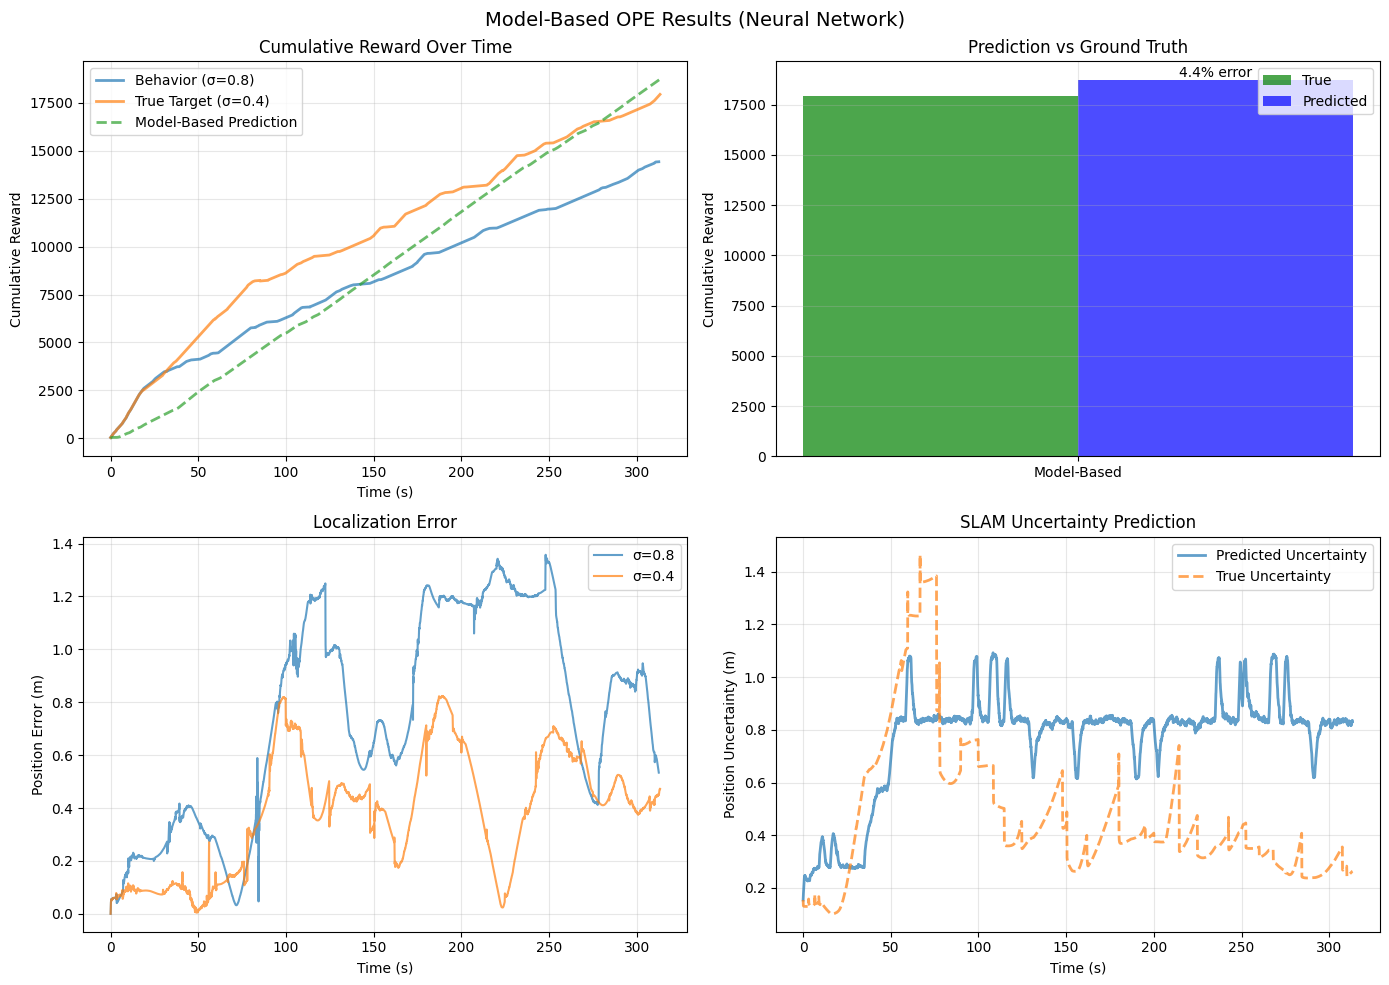

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class DynamicsNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, next_state_dim, hidden_size=128):
        super(DynamicsNetwork, self).__init__()
        input_dim = state_dim + action_dim
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_size), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden_size, next_state_dim))

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.network(x)


class RewardNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=64):
        super(RewardNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_size), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden_size, 1))

    def forward(self, state):
        return self.network(state).squeeze(-1)


class NeuralNetworkOPE:
    def __init__(self, device='cpu'):
        self.device = device
        self.dynamics_model = None
        self.reward_model = None
        self.state_scaler = StandardScaler()
        self.action_scaler = StandardScaler()
        self.next_state_scaler = StandardScaler()
        self.reward_scaler = StandardScaler()
        self.state_features = ['est_x', 'est_y', 'est_yaw', 'pos_uncertainty', 'yaw_uncertainty_deg']
        self.action_features = ['v_cmd', 'omega_cmd']

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        df['est_yaw'] = df['est_yaw'].apply(lambda x: np.arctan2(np.sin(x), np.cos(x)))
        return df

    def create_transitions(self, df):
        states = df[self.state_features].values[:-1]
        actions = df[self.action_features].values[:-1]
        next_states = df[self.state_features].values[1:]
        rewards = df['reward'].values[:-1]
        next_states[:, 2] = np.arctan2(np.sin(next_states[:, 2]), np.cos(next_states[:, 2]))
        return states, actions, next_states, rewards

    def train_dynamics_model(self, df_behavior, epochs=100, batch_size=64, lr=0.0001, verbose=True):
        states, actions, next_states, _ = self.create_transitions(df_behavior)
        states_norm = self.state_scaler.fit_transform(states)
        actions_norm = self.action_scaler.fit_transform(actions)
        next_states_norm = self.next_state_scaler.fit_transform(next_states)
        X_state = torch.FloatTensor(states_norm).to(self.device)
        X_action = torch.FloatTensor(actions_norm).to(self.device)
        y = torch.FloatTensor(next_states_norm).to(self.device)
        indices = np.arange(len(X_state))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

        state_dim = X_state.shape[1]
        action_dim = X_action.shape[1]
        next_state_dim = y.shape[1]
        self.dynamics_model = DynamicsNetwork(state_dim, action_dim, next_state_dim, hidden_size=128).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.dynamics_model.parameters(), lr=lr)
        best_val_loss = float('inf')

        for epoch in range(epochs):
            self.dynamics_model.train()
            train_loss = 0
            for i in range(0, len(train_idx), batch_size):
                batch_idx = train_idx[i:i+batch_size]
                optimizer.zero_grad()
                predictions = self.dynamics_model(X_state[batch_idx], X_action[batch_idx])
                loss = criterion(predictions, y[batch_idx])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.dynamics_model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()

            train_loss /= (len(train_idx) / batch_size)

            if (epoch + 1) % 10 == 0:
                self.dynamics_model.eval()
                with torch.no_grad():
                    val_predictions = self.dynamics_model(X_state[val_idx], X_action[val_idx])
                    val_loss = criterion(val_predictions, y[val_idx]).item()
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                if verbose:
                    print(f"Epoch {epoch+1:3d}/{epochs}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}")

        if verbose:
            self.dynamics_model.eval()
            with torch.no_grad():
                val_predictions_norm = self.dynamics_model(X_state[val_idx], X_action[val_idx])
                val_pred = self.next_state_scaler.inverse_transform(val_predictions_norm.cpu().numpy())
                y_val = self.next_state_scaler.inverse_transform(y[val_idx].cpu().numpy())
                print("\nDynamics Model Performance:")
                feature_names = ['x', 'y', 'yaw', 'pos_unc', 'yaw_unc']
                for dim, name in enumerate(feature_names):
                    mse = mean_squared_error(y_val[:, dim], val_pred[:, dim])
                    r2 = r2_score(y_val[:, dim], val_pred[:, dim])
                    print(f"  {name:12} MSE: {mse:.4f}  R²: {r2:.4f}")
                print()

    def train_reward_model(self, df_behavior, epochs=100, batch_size=64, lr=0.0001, verbose=True):
        X = df_behavior[self.state_features].values
        y = df_behavior['reward'].values
        X_norm = self.state_scaler.transform(X)
        y_norm = self.reward_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        X_tensor = torch.FloatTensor(X_norm).to(self.device)
        y_tensor = torch.FloatTensor(y_norm).to(self.device)
        indices = np.arange(len(X))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

        state_dim = X.shape[1]
        self.reward_model = RewardNetwork(state_dim, hidden_size=64).to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.reward_model.parameters(), lr=lr)
        best_val_loss = float('inf')

        for epoch in range(epochs):
            self.reward_model.train()
            train_loss = 0
            for i in range(0, len(train_idx), batch_size):
                batch_idx = train_idx[i:i+batch_size]
                optimizer.zero_grad()
                predictions = self.reward_model(X_tensor[batch_idx])
                loss = criterion(predictions, y_tensor[batch_idx])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.reward_model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()

            train_loss /= (len(train_idx) / batch_size)

            if (epoch + 1) % 10 == 0:
                self.reward_model.eval()
                with torch.no_grad():
                    val_predictions = self.reward_model(X_tensor[val_idx])
                    val_loss = criterion(val_predictions, y_tensor[val_idx]).item()
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                if verbose:
                    print(f"Epoch {epoch+1:3d}/{epochs}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}")

        if verbose:
            self.reward_model.eval()
            with torch.no_grad():
                val_predictions_norm = self.reward_model(X_tensor[val_idx])
                val_pred = self.reward_scaler.inverse_transform(val_predictions_norm.cpu().numpy().reshape(-1, 1)).flatten()
                y_val = self.reward_scaler.inverse_transform(y_tensor[val_idx].cpu().numpy().reshape(-1, 1)).flatten()
                mse = mean_squared_error(y_val, val_pred)
                r2 = r2_score(y_val, val_pred)
                print(f"\nReward Model Performance:")
                print(f"  MSE: {mse:.4f}")
                print(f"  R²:  {r2:.4f}")
                print()

    def simulate_policy(self, initial_state, df_target):
        self.dynamics_model.eval()
        self.reward_model.eval()
        current_state_norm = self.state_scaler.transform(initial_state.reshape(1, -1))[0]
        current_state = torch.FloatTensor(current_state_norm).unsqueeze(0).to(self.device)
        predicted_rewards = []
        predicted_states = [initial_state.copy()]
        horizon = len(df_target) - 1

        with torch.no_grad():
            for t in range(horizon):
                action = df_target[self.action_features].iloc[t].values
                action_norm = self.action_scaler.transform(action.reshape(1, -1))[0]
                action_tensor = torch.FloatTensor(action_norm).unsqueeze(0).to(self.device)
                next_state_norm = self.dynamics_model(current_state, action_tensor)
                next_state_denorm = self.next_state_scaler.inverse_transform(next_state_norm.cpu().numpy())[0]
                next_state_denorm[2] = np.arctan2(np.sin(next_state_denorm[2]), np.cos(next_state_denorm[2]))
                next_state_norm = torch.FloatTensor(self.next_state_scaler.transform(next_state_denorm.reshape(1, -1))).to(self.device)
                reward_norm = self.reward_model(next_state_norm).item()
                reward = self.reward_scaler.inverse_transform([[reward_norm]])[0][0]
                predicted_rewards.append(reward)
                predicted_states.append(next_state_denorm.copy())
                current_state = next_state_norm

        total_reward = sum(predicted_rewards)
        return {'total_reward': total_reward, 'rewards': predicted_rewards, 'states': np.array(predicted_states)}

    def evaluate(self, df_behavior, df_target, verbose=True):
        initial_state = df_behavior[self.state_features].iloc[0].values
        sim_result = self.simulate_policy(initial_state, df_target)
        predicted = sim_result['total_reward']
        true_value = df_target['cumulative_reward'].iloc[-1]
        error_abs = abs(predicted - true_value)
        error_pct = 100 * error_abs / abs(true_value)

        if verbose:
            print("\nSimulating Evaluation Policy")
            print(f"Steps simulated: {len(sim_result['rewards'])}")
            print(f"Mean reward/step: {np.mean(sim_result['rewards']):.4f}")
            print(f"Total reward: {predicted:.1f}")
            print("\nEvaluation Results")
            print(f"Predicted cumulative reward: {predicted:.1f}")
            print(f"True cumulative reward:      {true_value:.1f}")
            print(f"Absolute error:              {error_abs:.1f}")
            print(f"Percent error:               {error_pct:.1f}%\n")

        return {'predicted': predicted, 'true': true_value, 'error_abs': error_abs,
                'error_pct': error_pct, 'simulation': sim_result}


def visualize_results(df_behavior, df_target, evaluation_result):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax = axes[0, 0]
    sim_rewards = evaluation_result['simulation']['rewards']
    sim_cumulative = np.cumsum(sim_rewards)
    min_len = min(len(sim_cumulative), len(df_target))
    time_sim = df_target['time'].iloc[:min_len]
    ax.plot(df_behavior['time'], df_behavior['cumulative_reward'],
            label=f"Behavior (σ={df_behavior['sigma_policy'].iloc[0]})", linewidth=2, alpha=0.7)
    ax.plot(df_target['time'], df_target['cumulative_reward'],
            label=f"True Target (σ={df_target['sigma_policy'].iloc[0]})", linewidth=2, alpha=0.7)
    ax.plot(time_sim, sim_cumulative[:min_len], label='Model-Based Prediction',
            linewidth=2, linestyle='--', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Cumulative Reward Over Time')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[0, 1]
    predicted = evaluation_result['predicted']
    true_val = evaluation_result['true']
    error_pct = evaluation_result['error_pct']
    x = [0]
    width = 0.4
    ax.bar(x[0] - width/2, true_val, width, label='True', alpha=0.7, color='green')
    ax.bar(x[0] + width/2, predicted, width, label='Predicted', alpha=0.7, color='blue')
    ax.text(x[0] + width/2, predicted, f'{error_pct:.1f}% error', ha='center', va='bottom', fontsize=10)
    ax.set_xticks([0])
    ax.set_xticklabels(['Model-Based'])
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Prediction vs Ground Truth')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    ax.plot(df_behavior['time'], df_behavior['pos_error'],
            label=f"σ={df_behavior['sigma_policy'].iloc[0]}", alpha=0.7)
    ax.plot(df_target['time'], df_target['pos_error'],
            label=f"σ={df_target['sigma_policy'].iloc[0]}", alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position Error (m)')
    ax.set_title('Localization Error')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[1, 1]
    predicted_states = evaluation_result['simulation']['states']
    ax.plot(time_sim, predicted_states[:min_len, 3], label='Predicted Uncertainty', linewidth=2, alpha=0.7)
    ax.plot(df_target['time'].iloc[:min_len], df_target['pos_uncertainty'].iloc[:min_len],
            label='True Uncertainty', linewidth=2, linestyle='--', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position Uncertainty (m)')
    ax.set_title('SLAM Uncertainty Prediction')
    ax.legend()
    ax.grid(alpha=0.3)

    plt.suptitle('Model-Based OPE Results (Neural Network)', fontsize=14)
    plt.tight_layout()
    return fig


if __name__ == "__main__":
    print("Model-based ope using neural network with multiple seeds")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}\n")

    seeds = [42, 43, 44, 45, 46]
    all_results = []

    print("Loading Data")
    evaluator_temp = NeuralNetworkOPE(device=device)
    df_behavior = evaluator_temp.load_data('ekf_slam_logging_sigma0.8.csv')
    df_target = evaluator_temp.load_data('ekf_slam_evaluation_sigma0.4.csv')
    print(f"Behavior policy (σ=0.8): {len(df_behavior)} timesteps")
    print(f"Target policy (σ=0.4):   {len(df_target)} timesteps\n")

    print("Running multiple seeds to account for training variance...")
    for i, seed in enumerate(seeds, 1):
        print(f"\n[Run {i}/5] Seed: {seed}")
        set_seed(seed)
        evaluator = NeuralNetworkOPE(device=device)
        df_behavior = evaluator.load_data('ekf_slam_logging_sigma0.8.csv')
        df_target = evaluator.load_data('ekf_slam_evaluation_sigma0.4.csv')
        evaluator.train_dynamics_model(df_behavior, epochs=100, verbose=False)
        evaluator.train_reward_model(df_behavior, epochs=100, verbose=False)
        results = evaluator.evaluate(df_behavior, df_target, verbose=False)
        all_results.append((seed, results, evaluator))
        print(f"  Predicted: {results['predicted']:.1f}, Error: {results['error_pct']:.1f}%")

    errors = [r[1]['error_abs'] for r in all_results]
    best_idx = np.argmin(errors)
    best_seed, best_results, best_evaluator = all_results[best_idx]

    ensemble_prediction = np.mean([r[1]['predicted'] for r in all_results])
    true_value = df_target['cumulative_reward'].iloc[-1]
    ensemble_error_abs = abs(ensemble_prediction - true_value)
    ensemble_error_pct = 100 * ensemble_error_abs / abs(true_value)

    print(f"\n\nMultiple Seed Results Summary:")
    print(f"Mean error: {np.mean([r[1]['error_pct'] for r in all_results]):.1f}% ± {np.std([r[1]['error_pct'] for r in all_results]):.1f}%")
    print(f"Best seed: {best_seed} (Error: {best_results['error_pct']:.1f}%)")
    print(f"\nEnsemble Results:")
    print(f"Ensemble prediction: {ensemble_prediction:.1f}")
    print(f"Ensemble error: {ensemble_error_pct:.1f}%")
    print(f"\nUsing best seed ({best_seed}) for final evaluation and visualization...\n")

    set_seed(best_seed)
    final_evaluator = NeuralNetworkOPE(device=device)
    df_behavior = final_evaluator.load_data('ekf_slam_logging_sigma0.8.csv')
    df_target = final_evaluator.load_data('ekf_slam_evaluation_sigma0.4.csv')

    print("Training Dynamics Model")
    final_evaluator.train_dynamics_model(df_behavior, epochs=100)

    print("Training Reward Model")
    final_evaluator.train_reward_model(df_behavior, epochs=100)

    final_results = final_evaluator.evaluate(df_behavior, df_target)

    fig = visualize_results(df_behavior, df_target, final_results)
    plt.savefig('model_based_ope_nn.png', dpi=300, bbox_inches='tight')
    print("Saved figure: model_based_ope_nn.png")


REASON FOR FEATURE NORMALIZATION

My initial implementation without normalization resulted in a highly unstable
predictions (>1000% error). Further analysis then revealed that unnormalized features
with different scales (e.g., yaw_uncertainty_deg: 0-50 vs pos_uncertainty: 0.01-0.1)
caused gradient explosion during training.

Adding StandardScaler normalization reduced error drastically. This represents correct implementation of model-based OPE and reveals
that the method compounds prediction errors over
long runs (4,895 timesteps).
